# Compare analyzers on MNIST

This notebook shows how saliency maps are computed for various methods on the MNIST dataset. We will first train a simple 3-layer MLP and then apply different methods. In the end we allow for a qualitive assesment by plotting the analysis as a grid.

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import imp
import numpy as np
import os

import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import tensorflow.keras.models as keras_models

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

## Data
Load the dataset and keep some images from the test set for the analysis.

In [4]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

## Model
The next part trains and evaluates a CNN.

In [5]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

scores = mnistutils.train_model(model, data, batch_size=128, epochs=20)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1394 - acc: 0.9576
Epoch 2/20
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0364 - acc: 0.9888
Epoch 3/20
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0214 - acc: 0.9930
Epoch 4/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0131 - acc: 0.9958
Epoch 5/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0096 - acc: 0.9968
Epoch 6/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0098 - acc: 0.9965
Epoch 7/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0065 - acc: 0.9979
Epoch 8/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0030 - acc: 0.9990
Epoch 9/20
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0065 - acc: 0.9977
Epoch 10/20
60000/60000 [==============================] - 

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [14]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.graymap,        "Gradient"),
    #("smoothgrad",            {"noise_scale": noise_scale,
    #                           "postprocess": "square"},mnistutils.graymap,        "SmoothGrad"),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    #("pattern.net",           {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"),

    # Interaction
    #("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    #("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"),
    #("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"),
    #("deep_lift.wrapper",     {"reference_inputs": ri}, mnistutils.heatmap,        "DeepLIFT Wrapper - Rescale"),
    #("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"},
    #                                                    mnistutils.heatmap,        "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"),
]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [15]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

Now we analyze each image with the different analyzers:

In [16]:
%%capture

n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = mnistutils.postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641ac050>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641ac050>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664160950>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664160950>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664149e60> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664149e60> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664149e60> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664149e60> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664149e60> with
    self: <innvestigate.layers.Max object at 0x7fc6d02bf5d0>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664149e60> with
    self: <innvestigate.layers.Max object at 0x7fc6d02bf5d0>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66418ed20>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66418ed20>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664160fd0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6d02bf5d0>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664160fd0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc66414f050> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc66414f050> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc66414f050> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc66414f050> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc66414f050> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc6d02bf5d0>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc66414f050> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc6d02bf5d0>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method _Map.call of <innvestigate.layers.Identity object at 0x7fc66415a690>>
    args: (<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>,)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Map.call of <innvestigate.layers.Identity object at 0x7fc66415a690>>
    args: (<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>,)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6ac2c65a0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6ac2c65a0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Map'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Map'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Map.call of <innvestigate.layers.Identity object at 0x7fc66415a690>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Map.call of <innvestigate.layers.Identity object at 0x7fc66415a690>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Map.call of <innvestigate.layers.Identity object at 0x7fc66415a690>> key <code object call at 0x7fc6f035f8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 272> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66415ae10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp6uz6tdfi)


INFO:tensorflow:Cache hit for entity <bound method _Map.call of <innvestigate.layers.Identity object at 0x7fc66415a690>> key <code object call at 0x7fc6f035f8a0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 272> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66415ae10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp6uz6tdfi)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc66415b0e0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc66415b0e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc66415b0e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc66415b0e0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc66415b0e0> with
    self: <innvestigate.layers.Identity object at 0x7fc66415a690>
    x: Tensor("conv2d_input:0", shape=(?, 28, 28, 1), dtype=float32)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc66415b0e0> with
    self: <innvestigate.layers.Identity object at 0x7fc66415a690>
    x: Tensor("conv2d_input:0", shape=(?, 28, 28, 1), dtype=float32)



INFO:tensorflow:Converted call: <built-in function isinstance>
    args: (<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <class 'list'>)
    kwargs: None



INFO:tensorflow:Converted call: <built-in function isinstance>
    args: (<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <class 'list'>)
    kwargs: None



INFO:tensorflow:Converted call: <bound method Identity._apply_map of <innvestigate.layers.Identity object at 0x7fc66415a690>>
    args: (<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>,)
    kwargs: None



INFO:tensorflow:Converted call: <bound method Identity._apply_map of <innvestigate.layers.Identity object at 0x7fc66415a690>>
    args: (<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66418ed20>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66418ed20>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Identity'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Identity'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Identity._apply_map of <innvestigate.layers.Identity object at 0x7fc66415a690>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Identity._apply_map of <innvestigate.layers.Identity object at 0x7fc66415a690>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Identity._apply_map of <innvestigate.layers.Identity object at 0x7fc66415a690>> key <code object _apply_map at 0x7fc6f035fae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 285> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66414b390>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_map in tmp_rkklzwi)


INFO:tensorflow:Cache hit for entity <bound method Identity._apply_map of <innvestigate.layers.Identity object at 0x7fc66415a690>> key <code object _apply_map at 0x7fc6f035fae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 285> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66414b390>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_map in tmp_rkklzwi)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_map at 0x7fc66415b4d0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_map at 0x7fc66415b4d0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_map at 0x7fc66415b4d0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_map at 0x7fc66415b4d0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_map at 0x7fc66415b4d0> with
    self: <innvestigate.layers.Identity object at 0x7fc66415a690>
    x: Tensor("conv2d_input:0", shape=(?, 28, 28, 1), dtype=float32)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_map at 0x7fc66415b4d0> with
    self: <innvestigate.layers.Identity object at 0x7fc66415a690>
    x: Tensor("conv2d_input:0", shape=(?, 28, 28, 1), dtype=float32)



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6ac352f90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6ac352f90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66418ff50>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66418ff50>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6ac352f90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6ac352f90>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6ac352f90>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66414bf50>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6ac352f90>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66414bf50>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6641670e0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6641670e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6641670e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6641670e0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6641670e0> with
    self: <innvestigate.layers.Max object at 0x7fc6ac352f90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6641670e0> with
    self: <innvestigate.layers.Max object at 0x7fc6ac352f90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6ac352f90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6ac352f90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c5a0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c5a0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6ac352f90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6ac352f90>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6ac352f90>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6641664d0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6ac352f90>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6641664d0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664167200> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664167200> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664167200> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664167200> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664167200> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc6ac352f90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664167200> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc6ac352f90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7fc664166150>>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>,)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7fc664166150>>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>,)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c5a0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c5a0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.OnesLike'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.OnesLike'>: default rule


INFO:tensorflow:Not whitelisted: <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7fc664166150>>: default rule


INFO:tensorflow:Not whitelisted: <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7fc664166150>>: default rule


INFO:tensorflow:Cache hit for entity <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7fc664166150>> key <code object call at 0x7fc6f035a300, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 99> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664171610>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpb4z4__oz)


INFO:tensorflow:Cache hit for entity <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7fc664166150>> key <code object call at 0x7fc6f035a300, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 99> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664171610>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpb4z4__oz)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664167710> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664167710> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664167710> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664167710> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664167710> with
    self: <innvestigate.layers.OnesLike object at 0x7fc664166150>
    x: Tensor("iNNvestigate_max_7/Max:0", shape=(1, ?), dtype=float32)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664167710> with
    self: <innvestigate.layers.OnesLike object at 0x7fc664166150>
    x: Tensor("iNNvestigate_max_7/Max:0", shape=(1, ?), dtype=float32)



INFO:tensorflow:Converted call: <function to_list at 0x7fc6f036e5f0>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_list at 0x7fc6f036e5f0>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036e5f0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036e5f0>: default rule


INFO:tensorflow:Not whitelisted: <function to_list at 0x7fc6f036e5f0>: default rule


INFO:tensorflow:Not whitelisted: <function to_list at 0x7fc6f036e5f0>: default rule


INFO:tensorflow:Cache hit for entity <function to_list at 0x7fc6f036e5f0> key <code object to_list at 0x7fc6f0369b70, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/__init__.py", line 45> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664171b90>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_list in tmpe7n1r1k5)


INFO:tensorflow:Cache hit for entity <function to_list at 0x7fc6f036e5f0> key <code object to_list at 0x7fc6f0369b70, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/__init__.py", line 45> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664171b90>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_list in tmpe7n1r1k5)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7fc664167320> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7fc664167320> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7fc664167320> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7fc664167320> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7fc664167320> with
    l: Tensor("iNNvestigate_max_7/Max:0", shape=(1, ?), dtype=float32)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7fc664167320> with
    l: Tensor("iNNvestigate_max_7/Max:0", shape=(1, ?), dtype=float32)



INFO:tensorflow:Converted call: <built-in function isinstance>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>, <class 'list'>)
    kwargs: None



INFO:tensorflow:Converted call: <built-in function isinstance>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>, <class 'list'>)
    kwargs: None



INFO:tensorflow:Converted call: <function ones_like at 0x7fc6f9af5b90>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>,)
    kwargs: None



INFO:tensorflow:Converted call: <function ones_like at 0x7fc6f9af5b90>
    args: (<tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>,)
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>, [<tf.Tensor 'ones_like_2/ones_like:0' shape=(1, ?) dtype=float32>]],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_7/Max:0' shape=(1, ?) dtype=float32>, [<tf.Tensor 'ones_like_2/ones_like:0' shape=(1, ?) dtype=float32>]],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640f6140>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640f6140>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640f7650>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640f7650>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6641715d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_22/gradients/iNNvestigate_max_7/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_22/gradients/iNNvestigate_max_7/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640f9b40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640f9b40>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664111350>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664111350>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171790>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>
    args: ([<tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_23/gradients/dense_4/MatMul_grad/MatMul:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>
    args: ([<tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_23/gradients/dense_4/MatMul_grad/MatMul:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641048c0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641048c0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664133110>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664133110>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664171f50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradient_wrt_24/gradients/dense/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradient_wrt_24/gradients/dense/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410d2d0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410d2d0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66410f0d0>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66410f0d0>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac082190>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_25/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_25/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664108370>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664108370>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664135b50>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664135b50>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640f7610>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>
    args: ([<tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_26/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>
    args: ([<tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_26/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640be050>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640be050>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664119190>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664119190>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d7a90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'gradient_wrt_27/gradients/conv2d_1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'gradient_wrt_27/gradients/conv2d_1/Conv2D_grad/Conv2DBackpropInput:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b94b0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b94b0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640cda10>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640cda10>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6ac352650>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6640e1550>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6640e1550>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c230>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c230>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6640e1550>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6640e1550>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6640e1550>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640e1ad0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc6640e1550>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640e1ad0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640cad40> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640cad40> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640cad40> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640cad40> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640cad40> with
    self: <innvestigate.layers.Max object at 0x7fc6640e1550>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640cad40> with
    self: <innvestigate.layers.Max object at 0x7fc6640e1550>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6640e1550>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6640e1550>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66414c500>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66414c500>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6640e1550>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6640e1550>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6640e1550>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640e1b90>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc6640e1550>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640e1b90>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640cab00> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640cab00> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640cab00> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640cab00> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640cab00> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc6640e1550>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640cab00> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc6640e1550>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_8/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_8/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_8/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_8/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664164eb0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664164eb0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664086950>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664086950>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66407de90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_29/gradients/iNNvestigate_max_8/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_29/gradients/iNNvestigate_max_8/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416d280>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416d280>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640931d0>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640931d0>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664082bd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradients_6/reversed_dense_1/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradients_6/reversed_dense_1/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416d280>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416d280>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664091310>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664091310>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1bd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_31/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_31/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416afa0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416afa0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664038610>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664038610>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6d02d1550>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664095090>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664095090>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b9c30>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b9c30>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664095090>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664095090>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664095090>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664054690>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664095090>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664054690>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640a2dd0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640a2dd0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640a2dd0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640a2dd0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640a2dd0> with
    self: <innvestigate.layers.Max object at 0x7fc664095090>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc6640a2dd0> with
    self: <innvestigate.layers.Max object at 0x7fc664095090>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664095090>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664095090>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640cc960>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640cc960>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664095090>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664095090>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664095090>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640546d0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664095090>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640546d0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640a2c20> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640a2c20> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640a2c20> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640a2c20> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640a2c20> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc664095090>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc6640a2c20> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc664095090>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_9/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_9/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_9/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_9/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664153e60>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664153e60>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664057490>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664057490>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664054cd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_33/gradients/iNNvestigate_max_9/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_33/gradients/iNNvestigate_max_9/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641172d0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641172d0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66408a490>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66408a490>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc66403ded0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradients_9/dense/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradients_9/dense/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640cc960>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640cc960>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664057d10>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664057d10>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664095b90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_35/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_35/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664153e60>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664153e60>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664057850>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664057850>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7bfa90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664066190>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664066190>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664108320>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664108320>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664066190>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664066190>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664066190>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640663d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc664066190>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc6640663d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664059d40> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664059d40> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664059d40> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664059d40> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664059d40> with
    self: <innvestigate.layers.Max object at 0x7fc664066190>
    x: [<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc664059d40> with
    self: <innvestigate.layers.Max object at 0x7fc664066190>
    x: [<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664066190>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664066190>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410da50>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410da50>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664066190>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664066190>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664066190>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664066cd0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc664066190>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664066cd0>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664059b00> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664059b00> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664059b00> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664059b00> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664059b00> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc664066190>
    x: [<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc664059b00> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc664066190>
    x: [<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_10/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_10/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>
    args: ([<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_10/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_10/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410a7d0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410a7d0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c74ea90>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c74ea90>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c744b10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_37/gradients/iNNvestigate_max_10/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_37/gradients/iNNvestigate_max_10/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416ab40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416ab40>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c76b090>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c76b090>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749d10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>
    args: ([<tf.Tensor 'gradient_wrt_38/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>
    args: ([<tf.Tensor 'gradient_wrt_38/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c550>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c550>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>: default rule


INFO:tensorflow:Entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>> is not cached for key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c767450>, frozenset())


INFO:tensorflow:Entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>> is not cached for key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c767450>, frozenset())


INFO:tensorflow:Converting <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>


INFO:tensorflow:Converting <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>


INFO:tensorflow:Source code of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    a, b = x
    return a / (b + iK.to_floatx(K.equal(b, K.constant(0))) * self._factor)




INFO:tensorflow:Source code of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    a, b = x
    return a / (b + iK.to_floatx(K.equal(b, K.constant(0))) * self._factor)




INFO:tensorflow:Compiled output of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('call', 'call_scope', ag__.STD) as call_scope:
    a, b = x
    do_return = True
    retval_ = call_scope.mark_return_value(a / (b + ag__.converted_call(iK.to_floatx, call_scope.callopts, (ag__.converted_call(K.equal, call_scope.callopts, (b, ag__.converted_call(K.constant, call_scope.callopts, (0,), None, call_scope)), None, call_scope),), None, call_scope) * self._factor))
  do_return,
  return ag__.retval(retval_)




INFO:tensorflow:Compiled output of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('call', 'call_scope', ag__.STD) as call_scope:
    a, b = x
    do_return = True
    retval_ = call_scope.mark_return_value(a / (b + ag__.converted_call(iK.to_floatx, call_scope.callopts, (ag__.converted_call(K.equal, call_scope.callopts, (b, ag__.converted_call(K.constant, call_scope.callopts, (0,), None, call_scope)), None, call_scope),), None, call_scope) * self._factor))
  do_return,
  return ag__.retval(retval_)




INFO:tensorflow:Compiled AST of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:13, QN: self, DEFINITIONS: (AnnotatedDef[140489394427536],), ORIG_DEFINITIONS: (AnnotatedDef[140489394324496],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:19, QN: x, DEFINITIONS: (AnnotatedDef[140489394429136],), ORIG_DEFINITIONS: (AnnotatedDef[140489394324240],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x, self)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedD

INFO:tensorflow:Compiled AST of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:13, QN: self, DEFINITIONS: (AnnotatedDef[140489394427536],), ORIG_DEFINITIONS: (AnnotatedDef[140489394324496],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:19, QN: x, DEFINITIONS: (AnnotatedDef[140489394429136],), ORIG_DEFINITIONS: (AnnotatedDef[140489394324240],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x, self)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedD

INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c707cb0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c707cb0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c707cb0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c707cb0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c707cb0> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>
    x: [<tf.Tensor 'gradient_wrt_38/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c707cb0> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c76b950>
    x: [<tf.Tensor 'gradient_wrt_38/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Whitelisted: <function constant at 0x7fc6f9af53b0>: DoNotConvert rule for tensorflow


INFO:tensorflow:Whitelisted: <function constant at 0x7fc6f9af53b0>: DoNotConvert rule for tensorflow


INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Whitelisted: <function equal at 0x7fc6f9afb0e0>: DoNotConvert rule for tensorflow


INFO:tensorflow:Whitelisted: <function equal at 0x7fc6f9afb0e0>: DoNotConvert rule for tensorflow


INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide/Equal:0' shape=(?, 10) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide/Equal:0' shape=(?, 10) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Entity <function to_floatx at 0x7fc6f036ed40> is not cached for key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c6c4350>, frozenset())


INFO:tensorflow:Entity <function to_floatx at 0x7fc6f036ed40> is not cached for key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c6c4350>, frozenset())


INFO:tensorflow:Converting <function to_floatx at 0x7fc6f036ed40>


INFO:tensorflow:Converting <function to_floatx at 0x7fc6f036ed40>


INFO:tensorflow:Source code of <function to_floatx at 0x7fc6f036ed40>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def to_floatx(x):
    return K.cast(x, K.floatx())




INFO:tensorflow:Source code of <function to_floatx at 0x7fc6f036ed40>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def to_floatx(x):
    return K.cast(x, K.floatx())




INFO:tensorflow:Compiled output of <function to_floatx at 0x7fc6f036ed40>:

# coding=utf-8
def tf__to_floatx(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('to_floatx', 'to_floatx_scope', ag__.STD) as to_floatx_scope:
    do_return = True
    retval_ = to_floatx_scope.mark_return_value(ag__.converted_call(K.cast, to_floatx_scope.callopts, (x, ag__.converted_call(K.floatx, to_floatx_scope.callopts, (), None, to_floatx_scope)), None, to_floatx_scope))
  do_return,
  return ag__.retval(retval_)




INFO:tensorflow:Compiled output of <function to_floatx at 0x7fc6f036ed40>:

# coding=utf-8
def tf__to_floatx(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('to_floatx', 'to_floatx_scope', ag__.STD) as to_floatx_scope:
    do_return = True
    retval_ = to_floatx_scope.mark_return_value(ag__.converted_call(K.cast, to_floatx_scope.callopts, (x, ag__.converted_call(K.floatx, to_floatx_scope.callopts, (), None, to_floatx_scope)), None, to_floatx_scope))
  do_return,
  return ag__.retval(retval_)




INFO:tensorflow:Compiled AST of <function to_floatx at 0x7fc6f036ed40>:

FunctionDef:
| name=u"tf__to_floatx"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: backend.py:30:14, QN: x, DEFINITIONS: (AnnotatedDef[140489394392784],), ORIG_DEFINITIONS: (AnnotatedDef[140489393964624],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x,)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140489394344464],)}
| | | ]
| | | value=NameConstant:
| | | | value=False
| | | ___pyct_anno={SCOPE: Scope{r=(), w=(do_return,)}, LIVE_VARS_IN: frozenset({to_floatx_scope.mark_return_value, ag__.retval, x, to_floatx_scope.callopts, ag__.FunctionScope, ag__, K.cast, K, ag__.UndefinedReturnValue,

INFO:tensorflow:Compiled AST of <function to_floatx at 0x7fc6f036ed40>:

FunctionDef:
| name=u"tf__to_floatx"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: backend.py:30:14, QN: x, DEFINITIONS: (AnnotatedDef[140489394392784],), ORIG_DEFINITIONS: (AnnotatedDef[140489393964624],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x,)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140489394344464],)}
| | | ]
| | | value=NameConstant:
| | | | value=False
| | | ___pyct_anno={SCOPE: Scope{r=(), w=(do_return,)}, LIVE_VARS_IN: frozenset({to_floatx_scope.mark_return_value, ag__.retval, x, to_floatx_scope.callopts, ag__.FunctionScope, ag__, K.cast, K, ag__.UndefinedReturnValue,

INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c722e60> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c722e60> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c722e60> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c722e60> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c722e60> with
    x: Tensor("safe_divide/Equal:0", shape=(?, 10), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c722e60> with
    x: Tensor("safe_divide/Equal:0", shape=(?, 10), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Whitelisted: <function floatx at 0x7fc6f9b40320>: DoNotConvert rule for tensorflow


INFO:tensorflow:Whitelisted: <function floatx at 0x7fc6f9b40320>: DoNotConvert rule for tensorflow


INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide/Equal:0' shape=(?, 10) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide/Equal:0' shape=(?, 10) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Whitelisted: <function cast at 0x7fc6f9af5e60>: DoNotConvert rule for tensorflow


INFO:tensorflow:Whitelisted: <function cast at 0x7fc6f9af5e60>: DoNotConvert rule for tensorflow


INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
    args: ([<tf.Tensor 'lambda_20/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_dense_4/MatMul:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
    args: ([<tf.Tensor 'lambda_20/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_dense_4/MatMul:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664164af0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664164af0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66408aa50>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc66408aa50>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
    args: ([<tf.Tensor 'lambda_21/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense_4/MatMul:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
    args: ([<tf.Tensor 'lambda_21/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense_4/MatMul:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640be0a0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640be0a0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664038bd0>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc664038bd0>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c7c6a90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>>
    args: ([<tf.Tensor 'add_1/add:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'add_2/add:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>>
    args: ([<tf.Tensor 'add_1/add:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'add_2/add:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416aeb0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416aeb0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>>: default rule


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c774250>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c774250>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c72f050> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c72f050> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c72f050> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c72f050> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c72f050> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>
    x: [<tf.Tensor 'add_1/add:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'add_2/add:0' shape=(?, 512) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c72f050> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c71d710>
    x: [<tf.Tensor 'add_1/add:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'add_2/add:0' shape=(?, 512) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'add_2/add:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_1/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'add_2/add:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_1/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_1/Equal:0' shape=(?, 512) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_1/Equal:0' shape=(?, 512) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c728b10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c728b10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c72f320> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c72f320> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c72f320> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c72f320> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c72f320> with
    x: Tensor("safe_divide_1/Equal:0", shape=(?, 512), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c72f320> with
    x: Tensor("safe_divide_1/Equal:0", shape=(?, 512), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_1/Equal:0' shape=(?, 512) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_1/Equal:0' shape=(?, 512) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
    args: ([<tf.Tensor 'lambda_24/mul:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_dense/MatMul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_1/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
    args: ([<tf.Tensor 'lambda_24/mul:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_dense/MatMul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_1/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664164af0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664164af0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c774650>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c774650>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
    args: ([<tf.Tensor 'lambda_25/mul:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense/MatMul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_1/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
    args: ([<tf.Tensor 'lambda_25/mul:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense/MatMul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_1/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640d5d70>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640d5d70>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c774910>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c774910>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664038ad0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'add_3/add:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'add_3/add:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664169230>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664169230>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c74ec90>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c74ec90>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc6640623d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_41/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_41/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641173c0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641173c0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c736090>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c736090>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c749350>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>>
    args: ([<tf.Tensor 'gradient_wrt_42/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>>
    args: ([<tf.Tensor 'gradient_wrt_42/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641abb40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641abb40>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>>: default rule


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c729250>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c729250>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4170> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4170> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4170> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4170> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4170> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>
    x: [<tf.Tensor 'gradient_wrt_42/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4170> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c6b9d90>
    x: [<tf.Tensor 'gradient_wrt_42/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_2/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_2/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_2/Equal:0' shape=(?, 24, 24, 64) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_2/Equal:0' shape=(?, 24, 24, 64) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c729e90>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c729e90>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6f4440> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6f4440> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6f4440> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6f4440> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6f4440> with
    x: Tensor("safe_divide_2/Equal:0", shape=(?, 24, 24, 64), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6f4440> with
    x: Tensor("safe_divide_2/Equal:0", shape=(?, 24, 24, 64), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_2/Equal:0' shape=(?, 24, 24, 64) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_2/Equal:0' shape=(?, 24, 24, 64) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
    args: ([<tf.Tensor 'lambda_28/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_conv2d_1/Conv2D:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_2/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
    args: ([<tf.Tensor 'lambda_28/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_conv2d_1/Conv2D:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_2/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66414caf0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66414caf0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c729f50>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c729f50>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
    args: ([<tf.Tensor 'lambda_29/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_conv2d_1/Conv2D:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_2/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
    args: ([<tf.Tensor 'lambda_29/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_conv2d_1/Conv2D:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_2/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c370>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c370>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c7296d0>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c7296d0>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c772590>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>>
    args: ([<tf.Tensor 'add_5/add:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'subtract/sub:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>>
    args: ([<tf.Tensor 'add_5/add:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'subtract/sub:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c69c410>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c69c410>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>>: default rule


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683b50>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683b50>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4b00> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4b00> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4b00> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4b00> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4b00> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>
    x: [<tf.Tensor 'add_5/add:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'subtract/sub:0' shape=(?, 26, 26, 32) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c6f4b00> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c6c4750>
    x: [<tf.Tensor 'add_5/add:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'subtract/sub:0' shape=(?, 26, 26, 32) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'subtract/sub:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'subtract/sub:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_3/Equal:0' shape=(?, 26, 26, 32) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_3/Equal:0' shape=(?, 26, 26, 32) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c68c490>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c68c490>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6a5290> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6a5290> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6a5290> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6a5290> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6a5290> with
    x: Tensor("safe_divide_3/Equal:0", shape=(?, 26, 26, 32), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6a5290> with
    x: Tensor("safe_divide_3/Equal:0", shape=(?, 26, 26, 32), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_3/Equal:0' shape=(?, 26, 26, 32) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_3/Equal:0' shape=(?, 26, 26, 32) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c687500>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c687500>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683e90>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683e90>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
    args: ([<tf.Tensor 'lambda_30/add:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
    args: ([<tf.Tensor 'lambda_30/add:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c67d190>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c67d190>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683e90>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683e90>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
    args: ([<tf.Tensor 'lambda_31/add:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
    args: ([<tf.Tensor 'lambda_31/add:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c685050>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c685050>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683f50>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c683f50>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc664066250>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c75fd90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c75fd90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641041e0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641041e0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c75fd90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c75fd90>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c75fd90>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c645610>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c75fd90>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c645610>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c7ed440> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c7ed440> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c7ed440> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c7ed440> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c7ed440> with
    self: <innvestigate.layers.Max object at 0x7fc63c75fd90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c7ed440> with
    self: <innvestigate.layers.Max object at 0x7fc63c75fd90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c75fd90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c75fd90>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664169690>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc664169690>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c75fd90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c75fd90>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c75fd90>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c645050>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c75fd90>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c645050>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c7ed5f0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c7ed5f0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c7ed5f0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c7ed5f0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c7ed5f0> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc63c75fd90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c7ed5f0> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc63c75fd90>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_11/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_11/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_11/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_11/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c6b4280>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c6b4280>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5fdb50>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5fdb50>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c672950>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>>
    args: ([<tf.Tensor 'gradient_wrt_45/gradients/iNNvestigate_max_11/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>>
    args: ([<tf.Tensor 'gradient_wrt_45/gradients/iNNvestigate_max_11/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b9c30>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b9c30>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>>: default rule


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c6140d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c6140d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656950> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656950> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656950> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656950> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656950> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>
    x: [<tf.Tensor 'gradient_wrt_45/gradients/iNNvestigate_max_11/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656950> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c5fd650>
    x: [<tf.Tensor 'gradient_wrt_45/gradients/iNNvestigate_max_11/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide_4/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide_4/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_4/Equal:0' shape=(?, 10) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_4/Equal:0' shape=(?, 10) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c614e10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c614e10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6569e0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6569e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6569e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6569e0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6569e0> with
    x: Tensor("safe_divide_4/Equal:0", shape=(?, 10), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c6569e0> with
    x: Tensor("safe_divide_4/Equal:0", shape=(?, 10), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_4/Equal:0' shape=(?, 10) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_4/Equal:0' shape=(?, 10) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide_4/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide_4/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b92d0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6640b92d0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c614690>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c614690>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c675810>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c614550>>
    args: ([<tf.Tensor 'multiply_9/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c614550>>
    args: ([<tf.Tensor 'multiply_9/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416ab40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66416ab40>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c614550>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c614550>>: default rule


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c614550>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c629b10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c614550>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c629b10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656ef0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656ef0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656ef0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656ef0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656ef0> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c614550>
    x: [<tf.Tensor 'multiply_9/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c656ef0> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c614550>
    x: [<tf.Tensor 'multiply_9/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_5/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_5/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_5/Equal:0' shape=(?, 512) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_5/Equal:0' shape=(?, 512) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c629a50>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c629a50>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c656f80> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c656f80> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c656f80> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c656f80> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c656f80> with
    x: Tensor("safe_divide_5/Equal:0", shape=(?, 512), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c656f80> with
    x: Tensor("safe_divide_5/Equal:0", shape=(?, 512), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_5/Equal:0' shape=(?, 512) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_5/Equal:0' shape=(?, 512) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>
    args: ([<tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_5/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>
    args: ([<tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_dense/BiasAdd:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'safe_divide_5/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641170a0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc6641170a0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c6293d0>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c6293d0>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c604b90>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'multiply_10/mul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'multiply_10/mul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c67d190>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c67d190>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c629250>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c629250>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5fd290>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_48/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_48/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c69c410>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c69c410>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c13d0>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c13d0>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c686590>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>>
    args: ([<tf.Tensor 'gradient_wrt_49/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>>
    args: ([<tf.Tensor 'gradient_wrt_49/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c634cd0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c634cd0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>>: default rule


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1ed0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1ed0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5cab90> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5cab90> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5cab90> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5cab90> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5cab90> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>
    x: [<tf.Tensor 'gradient_wrt_49/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5cab90> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c608a10>
    x: [<tf.Tensor 'gradient_wrt_49/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_6/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_6/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_6/Equal:0' shape=(?, 24, 24, 64) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_6/Equal:0' shape=(?, 24, 24, 64) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1f10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1f10>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c5cac20> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c5cac20> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c5cac20> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c5cac20> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c5cac20> with
    x: Tensor("safe_divide_6/Equal:0", shape=(?, 24, 24, 64), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c5cac20> with
    x: Tensor("safe_divide_6/Equal:0", shape=(?, 24, 24, 64), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_6/Equal:0' shape=(?, 24, 24, 64) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_6/Equal:0' shape=(?, 24, 24, 64) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>
    args: ([<tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_6/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>
    args: ([<tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_6/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5d88c0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5d88c0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5bc850>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5bc850>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c75fa50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>>
    args: ([<tf.Tensor 'multiply_11/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>>
    args: ([<tf.Tensor 'multiply_11/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5f2910>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5f2910>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>>: default rule


INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>>: default rule


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1e10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>> key <code object call at 0x7fc6f0365390, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1e10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9kk4dh64)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d3b0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d3b0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d3b0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d3b0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d3b0> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>
    x: [<tf.Tensor 'multiply_11/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d3b0> with
    self: <innvestigate.layers.SafeDivide object at 0x7fc63c5e9390>
    x: [<tf.Tensor 'multiply_11/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>]



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function constant at 0x7fc6f9af53b0>
    args: (0,)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_7/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function equal at 0x7fc6f9afb0e0>
    args: (<tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_7/Const:0' shape=() dtype=float32>)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_7/Equal:0' shape=(?, 26, 26, 32) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Converted call: <function to_floatx at 0x7fc6f036ed40>
    args: (<tf.Tensor 'safe_divide_7/Equal:0' shape=(?, 26, 26, 32) dtype=bool>,)
    kwargs: None



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of function object at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Not whitelisted: <function to_floatx at 0x7fc6f036ed40>: default rule


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c613050>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Cache hit for entity <function to_floatx at 0x7fc6f036ed40> key <code object to_floatx at 0x7fc6f036e4b0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/utils/keras/backend.py", line 30> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c613050>, frozenset()): _ConvertedEntityFactoryInfo(tf__to_floatx in tmp1spv1rn2)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c57d290> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c57d290> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c57d290> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c57d290> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c57d290> with
    x: Tensor("safe_divide_7/Equal:0", shape=(?, 26, 26, 32), dtype=bool)



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7fc63c57d290> with
    x: Tensor("safe_divide_7/Equal:0", shape=(?, 26, 26, 32), dtype=bool)



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function floatx at 0x7fc6f9b40320>
    args: ()
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_7/Equal:0' shape=(?, 26, 26, 32) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <function cast at 0x7fc6f9af5e60>
    args: (<tf.Tensor 'safe_divide_7/Equal:0' shape=(?, 26, 26, 32) dtype=bool>, 'float32')
    kwargs: None



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_7/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_7/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5f8230>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5f8230>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1dd0>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5c1dd0>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c614690>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c668810>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c668810>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66414c5a0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66414c5a0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers._Reduce'>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c668810>>: default rule


INFO:tensorflow:Not whitelisted: <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c668810>>: default rule


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c668810>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5ecc10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Cache hit for entity <bound method _Reduce.call of <innvestigate.layers.Max object at 0x7fc63c668810>> key <code object call at 0x7fc6f035af60, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 213> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5ecc10>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpt15ldub6)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d7a0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d7a0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d7a0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d7a0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d7a0> with
    self: <innvestigate.layers.Max object at 0x7fc63c668810>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d7a0> with
    self: <innvestigate.layers.Max object at 0x7fc63c668810>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c668810>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c668810>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c63d5f0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c63d5f0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Max'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c668810>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c668810>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c668810>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c586910>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Cache hit for entity <bound method Max._apply_reduce of <innvestigate.layers.Max object at 0x7fc63c668810>> key <code object _apply_reduce at 0x7fc6f035f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 244> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c586910>, frozenset()): _ConvertedEntityFactoryInfo(tf___apply_reduce in tmp5xzd7cfb)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c57d440> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c57d440> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c57d440> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c57d440> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c57d440> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc63c668810>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf___apply_reduce at 0x7fc63c57d440> with
    axis: -1
    keepdims: False
    self: <innvestigate.layers.Max object at 0x7fc63c668810>
    x: [<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <function max at 0x7fc6f9af83b0>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {'axis': -1, 'keepdims': False}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_12/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_12/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>
    args: ([<tf.Tensor 'dense_4/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_max_12/Max:0' shape=(1, ?) dtype=float32>, <tf.Tensor 'iNNvestigate_max_12/Max:0' shape=(1, ?) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c60d640>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c60d640>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5b0a50>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5b0a50>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5a79d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>
    args: ([<tf.Tensor 'gradient_wrt_52/gradients/iNNvestigate_max_12/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'lambda_32/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>
    args: ([<tf.Tensor 'gradient_wrt_52/gradients/iNNvestigate_max_12/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'lambda_32/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5ebdc0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5ebdc0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>: default rule


INFO:tensorflow:Entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>> is not cached for key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5415d0>, frozenset())


INFO:tensorflow:Entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>> is not cached for key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5415d0>, frozenset())


INFO:tensorflow:Converting <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>


INFO:tensorflow:Converting <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>


INFO:tensorflow:Source code of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    a, b = x
    return a / b




INFO:tensorflow:Source code of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    a, b = x
    return a / b




INFO:tensorflow:Compiled output of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('call', 'call_scope', ag__.STD) as call_scope:
    a, b = x
    do_return = True
    retval_ = call_scope.mark_return_value(a / b)
  do_return,
  return ag__.retval(retval_)




INFO:tensorflow:Compiled output of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('call', 'call_scope', ag__.STD) as call_scope:
    a, b = x
    do_return = True
    retval_ = call_scope.mark_return_value(a / b)
  do_return,
  return ag__.retval(retval_)




INFO:tensorflow:Compiled AST of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:13, QN: self, DEFINITIONS: (AnnotatedDef[140489392592592],), ORIG_DEFINITIONS: (AnnotatedDef[140489392503440],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:19, QN: x, DEFINITIONS: (AnnotatedDef[140489392590928],), ORIG_DEFINITIONS: (AnnotatedDef[140489392503376],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x, self)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[14048

INFO:tensorflow:Compiled AST of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c62eb10>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:13, QN: self, DEFINITIONS: (AnnotatedDef[140489392592592],), ORIG_DEFINITIONS: (AnnotatedDef[140489392503440],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:19, QN: x, DEFINITIONS: (AnnotatedDef[140489392590928],), ORIG_DEFINITIONS: (AnnotatedDef[140489392503376],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x, self)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[14048

INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d9e0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d9e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d9e0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d9e0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d9e0> with
    self: <innvestigate.layers.Divide object at 0x7fc63c62eb10>
    x: [<tf.Tensor 'gradient_wrt_52/gradients/iNNvestigate_max_12/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'lambda_32/add:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c57d9e0> with
    self: <innvestigate.layers.Divide object at 0x7fc63c62eb10>
    x: [<tf.Tensor 'gradient_wrt_52/gradients/iNNvestigate_max_12/Max/input_grad/unstack:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'lambda_32/add:0' shape=(?, 10) dtype=float32>]



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4_1/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_4_1/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5ebb90>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c5ebb90>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5b8a50>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c5b8a50>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b0f10>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c5c1910>>
    args: ([<tf.Tensor 'multiply_13/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_33/add:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c5c1910>>
    args: ([<tf.Tensor 'multiply_13/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_33/add:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c63c190>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c63c190>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c5c1910>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c5c1910>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c5c1910>> key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c577890>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpsjon_h7p)


INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c5c1910>> key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c577890>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpsjon_h7p)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c56e950> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c56e950> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c56e950> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c56e950> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c56e950> with
    self: <innvestigate.layers.Divide object at 0x7fc63c5c1910>
    x: [<tf.Tensor 'multiply_13/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_33/add:0' shape=(?, 512) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c56e950> with
    self: <innvestigate.layers.Divide object at 0x7fc63c5c1910>
    x: [<tf.Tensor 'multiply_13/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_33/add:0' shape=(?, 512) dtype=float32>]



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>
    args: ([<tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_1/BiasAdd:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'divide_1/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>
    args: ([<tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_1/BiasAdd:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'divide_1/truediv:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c69c4b0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c69c4b0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c577350>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c577350>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5d50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'multiply_14/mul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'multiply_14/mul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c6a7190>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c6a7190>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c4fb110>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c4fb110>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5710d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_55/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_55/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410d3c0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66410d3c0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c501950>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c501950>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c588d50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55ead0>>
    args: ([<tf.Tensor 'gradient_wrt_56/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'lambda_34/add:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55ead0>>
    args: ([<tf.Tensor 'gradient_wrt_56/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'lambda_34/add:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c690>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc66415c690>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55ead0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55ead0>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55ead0>> key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c501250>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpsjon_h7p)


INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55ead0>> key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c501250>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpsjon_h7p)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5164d0> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5164d0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5164d0> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5164d0> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5164d0> with
    self: <innvestigate.layers.Divide object at 0x7fc63c55ead0>
    x: [<tf.Tensor 'gradient_wrt_56/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'lambda_34/add:0' shape=(?, 24, 24, 64) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c5164d0> with
    self: <innvestigate.layers.Divide object at 0x7fc63c55ead0>
    x: [<tf.Tensor 'gradient_wrt_56/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'lambda_34/add:0' shape=(?, 24, 24, 64) dtype=float32>]



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>
    args: ([<tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'divide_2/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>
    args: ([<tf.Tensor 'conv2d/Relu:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'divide_2/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c687550>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c687550>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c501190>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c501190>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5b5f50>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55b790>>
    args: ([<tf.Tensor 'multiply_15/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'lambda_35/add:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55b790>>
    args: ([<tf.Tensor 'multiply_15/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'lambda_35/add:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c52be10>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c52be10>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55b790>>: default rule


INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55b790>>: default rule


INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55b790>> key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c4fef50>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpsjon_h7p)


INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7fc63c55b790>> key <code object call at 0x7fc6f0365150, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c4fef50>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmpsjon_h7p)


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c516b90> : None


INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c516b90> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c516b90> : None


INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c516b90> : None


INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c516b90> with
    self: <innvestigate.layers.Divide object at 0x7fc63c55b790>
    x: [<tf.Tensor 'multiply_15/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'lambda_35/add:0' shape=(?, 26, 26, 32) dtype=float32>]



INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7fc63c516b90> with
    self: <innvestigate.layers.Divide object at 0x7fc63c55b790>
    x: [<tf.Tensor 'multiply_15/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'lambda_35/add:0' shape=(?, 26, 26, 32) dtype=float32>]



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_3/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>
    args: ([<tf.Tensor 'conv2d_input:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_3/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}



INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c52b5a0>: default rule


INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7fc63c52b5a0>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>: default rule


INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>: default rule


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c4fe910>, frozenset())


INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>> is not cached for key <code object call at 0x7fc6f035aae0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fc63c4fe910>, frozenset())


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>


INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>


INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret




INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7fc63c5c1bd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Next, we visualize the analysis results:

<Figure size 432x288 with 0 Axes>

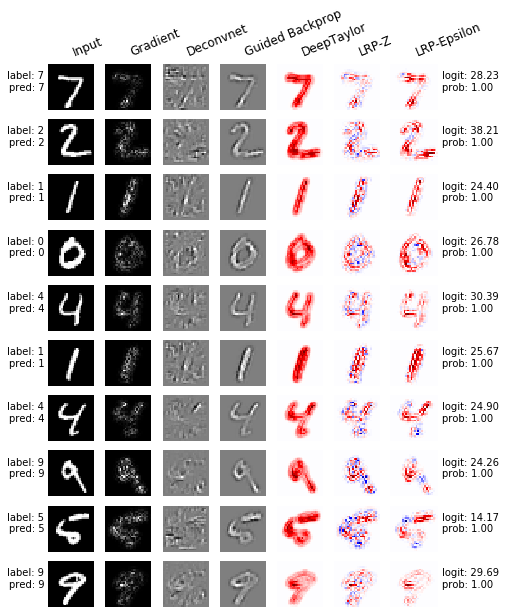

In [17]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))

<Figure size 432x288 with 0 Axes>

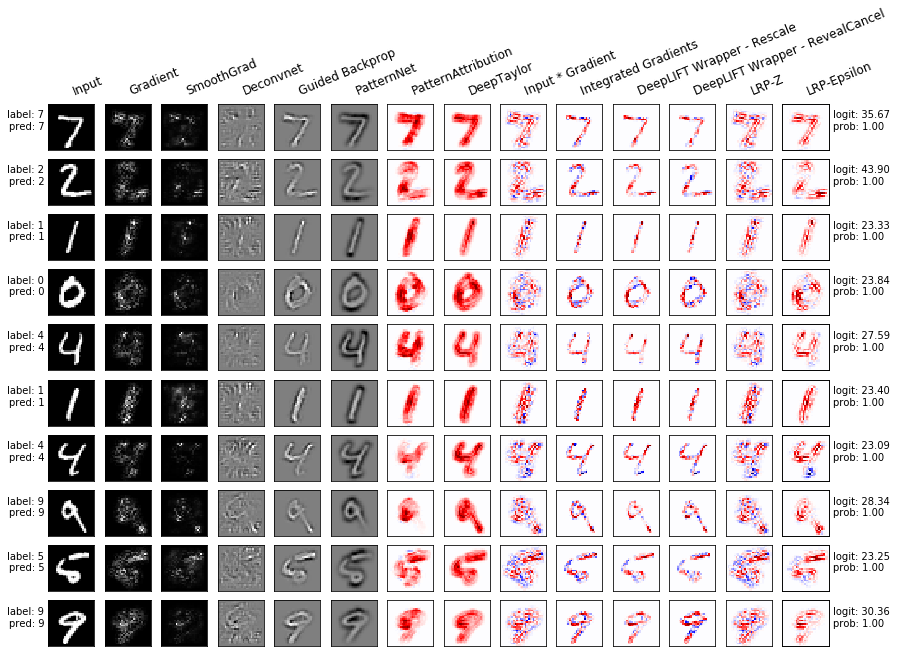

In [8]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))

Each column shows the visualized results for different analyzers and each row shows the analyses w.r.t. to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).

This figure shows the analysis w.r.t. to most activated neuron, e.g., *actually predicted* class. To see how to analyze the prediction w.r.t. to other neurons/classes have a look here: [Analyzing different classes with MNIST](mnist_neuron_selection.ipynb)

If you are curious about how *iNNvestigate* performs on ImageNet model, have a look here: [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)